In [2]:
import networkx as nx
import numpy as np
import scipy
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
matplotlib.rcParams.update({'font.size': 15})
import csv
import os
import itertools

In [3]:
from scripts.utility import *
from scripts.features import *

# Features

## 1. Geometrical

### 1.1 Number of nodes and edges

In [ ]:
save_feature(n_nodes, skip_existing=True, clean=False)
save_feature(n_edges, skip_existing=True, clean=False)

### 1.2 Average node degree

In [ ]:
save_feature(average_node_degree, skip_existing=True, clean=False)

### 1.3 Vein density

Vein density **$\sigma$** is calculated by summing the total length of all veins and dividing by total leaf area.


In [ ]:
save_feature(vein_density, skip_existing=True, clean=False)

### 1.4 Areole area

Areole area **$A$** is obtained calculating basic cycle areas using the standard formula for the area of a general polygon.

In [ ]:
save_feature(areole_area, skip_existing=True, clean=False)

### 1.5 Areole density 

Areole density **$\rho_A$** is the total number of areoles divided by leaf area.

In [ ]:
save_feature(areole_density, skip_existing=True, clean=False)

### 1.6 Weighted vein thickness

Weighted vein thickness **$d$** is calculated as the total sum of the product radius*length of each
    individual vein segment divided by total vein length

In [ ]:
save_feature(weighted_vein_thickness, skip_existing=True, clean=False)

## 2. Topological

### 2.1 Nesting number

In [ ]:
save_feature(nesting_numbers, skip_existing=True, clean=True)

### 2.2 Topological length

In [ ]:
save_feature(topological_length, skip_existing=True, clean=True)

# Data Analysis

In [4]:
data = read_features()

feature_names = [
    'topological_length',  
    #'nesting_number_weighted_no_ext',
    #'nesting_number_unweighted',
    #'nesting_number_weighted',
    'nesting_number_unweighted_no_ext',
    'vein_density',
    'vein_distance',
    'areole_area',
    'areole_density',
    'weighted_vein_thickness',
    #'average_node_degree',
    #'n_edges',
    #'n_nodes',
    
]

feature_labels = {
    'topological_length'              : r'$L_{top}$',
    'nesting_number_weighted'         : r'$i_w$',
    'nesting_number_weighted_no_ext'  : r'$i_w^{no}$',
    'nesting_number_unweighted'       : r'$i_u$',
    'nesting_number_unweighted_no_ext': r'$i$',
    'vein_density'                    : r'$\sigma$',
    'vein_distance'                   : r'$a$',
    'areole_area'                     : r'$A$',
    'areole_density'                  : r'$\rho_A$',
    'weighted_vein_thickness'         : r'$d$',
    'average_node_degree'             : r'$deg_N$',
    'n_edges'                         : r'$N_e$',
    'n_nodes'                         : r'$N_n$',
}

# Use keys of nesting number data because some entries are missing there
network_ids = sorted(data['nesting_number_weighted'].keys())

## Visualize one leaf

Removing disconnected parts
Removing nodes with same positions.


/Users/Ben/anaconda3/envs/leaf/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/Ben/anaconda3/envs/leaf/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/Ben/anaconda3/envs/leaf/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/Ben/anaconda3/envs/leaf/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 

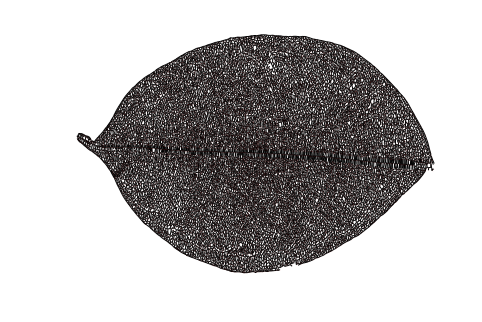

In [12]:
base_path = 'data/networks-BronxA/BronxA_001_binary_graph.{}.txt'

network_id, G = graph_from_data(base_path.format('node_positions'), base_path.format('edgelist'))
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos=pos, node_size=0.0001, edge_size=0.01)

## Principal Component Analysis

In [5]:
X = []
for feature_name in feature_names:
    row = [data[feature_name][network_id] for network_id in network_ids]
    X.append(row)
X = np.array(X)
X = X.T

# Remove the one big outlier
X = np.array([row for row in X if row[5] < 300000])

X = X - np.mean(X, axis=0)

# X1 is normalized with uniform standard deviation to see the direction of the variance,
# X2 is normalized by dividing with maximum valus to see relative magnitude of variance.
X1 = X / np.std(X, axis=0)
X2 = X / np.max(X, axis=0)

[ 0.44441519  0.26358116  0.14571999  0.07905538  0.03369294  0.01931406
  0.01422129]


<IPython.core.display.Javascript object>


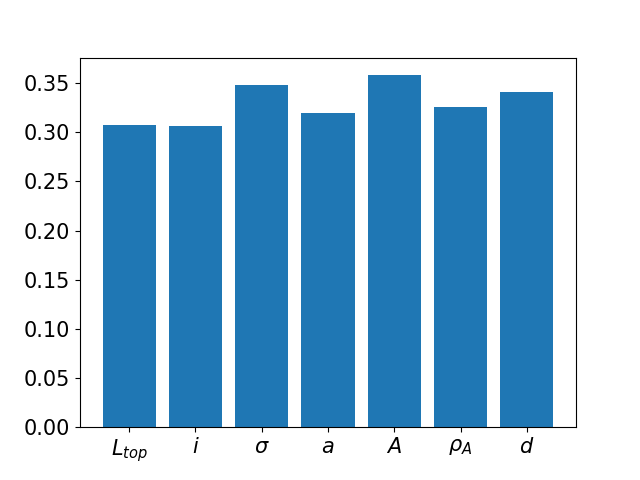

<IPython.core.display.Javascript object>


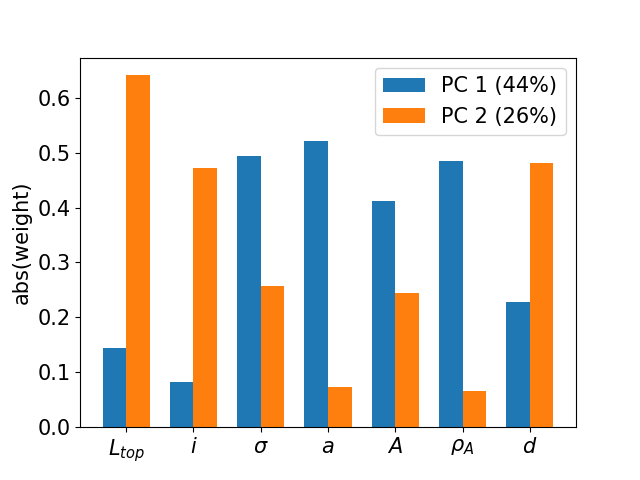

[ 0.45966621  0.25779362  0.20634045  0.04044388  0.02222354  0.01021964
  0.00331267]


<IPython.core.display.Javascript object>


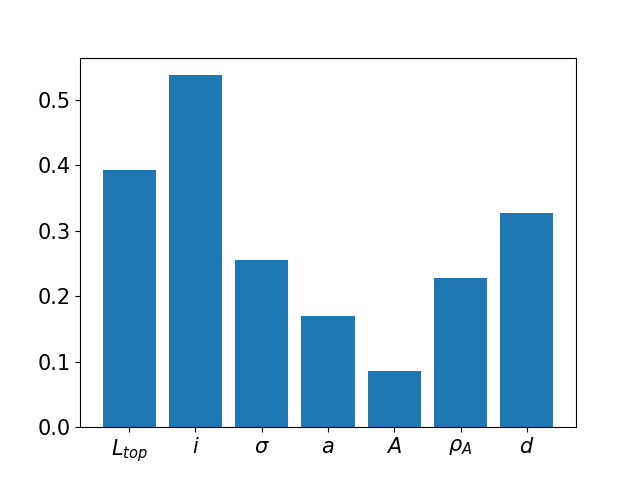

<IPython.core.display.Javascript object>


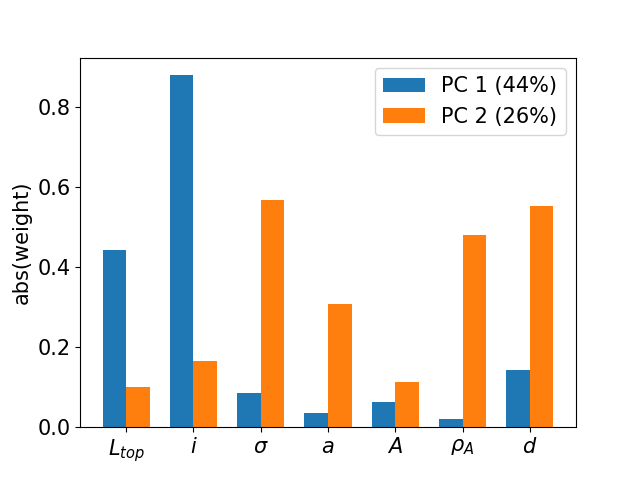

In [6]:
for X in [X1, X2]:
    pca = PCA()
    pca.fit(X)
    
    normalized_eigenvalues = pca.explained_variance_ratio_
    print(normalized_eigenvalues)
    
    principal_components = pca.components_    
    scaled_principal_components = (normalized_eigenvalues * principal_components.T).T    
    relative_feature_contributions = np.sum(abs(scaled_principal_components), axis=0)
    
    # Plot total total contributions of feature to the variance by summing the
    # corresponding weights of the principal components multiplied with the
    # normalized eigenvalues.
    fig, ax = plt.subplots()
    x = np.arange(len(relative_feature_contributions))
    ax.bar(x, relative_feature_contributions)
    labels = [feature_labels[name] for name in feature_names]
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    
    # Plot PC1 and PC2
    width = 0.35
    fig, ax = plt.subplots()
    x = np.arange(len(relative_feature_contributions))
    ax.bar(x, abs(principal_components[0,:]), width, label='PC 1 (44%)')
    ax.bar(x + width, abs(principal_components[1,:]), width, label='PC 2 (26%)')

    labels = [feature_labels[name] for name in feature_names]
    ax.set_xticks(x + width/2)
    ax.set_xticklabels(labels)
    ax.set_ylabel('abs(weight)')
    ax.legend()

## Clustering

### Cluster genera with >20 species

In [15]:
# Minimum amount of species in a genus
n_subset = 20

# Get all genera with more than 20 species and the corresponding network_ids
species = [species_from_id(network_id) for network_id in network_ids]
genera = list(sorted(set([spec['genus'] for spec in species])))
networks_from_genus = {genus: [] for genus in genera}
for network_id in network_ids:
    networks_from_genus[species_from_id(network_id)['genus']].append(network_id)
genera_ge4 = []
for genus, networks in networks_from_genus.items():
    if len(networks) >= n_subset:
        genera_ge4.append(genus)
        print(genus)
        
network_ids_ge4 = list(itertools.chain(*[networks_from_genus[genus][:n_subset] for genus in genera_ge4]))

Bursera
Parkia
Protium


In [8]:
X = []
for feature_name in feature_names:
    row = [data[feature_name][network_id] for network_id in network_ids_ge4]
    X.append(row)
X = np.array(X)
X = X.T

# Remove the one big outlier
for k, row in enumerate(list(X)):
    if row[4] > 300000:
        del network_ids_ge4[k]
X = np.array([row for row in X if row[4] < 300000])

X = X - np.mean(X, axis=0)
X = X / np.std(X, axis=0)

In [9]:
kmeans = KMeans(n_clusters=len(genera_ge4), n_init=60).fit(X)

In [16]:
# For every cluster center, cound the number of feature vectors of the
# different genera that are closest to this center
count_matrix = np.zeros((len(genera_ge4), len(genera_ge4)), dtype=int)
for k in range(len(genera_ge4)):
    labels = kmeans.labels_[k*n_subset:(k+1)*n_subset]
    unique, counts = np.unique(labels, return_counts=True)
    for index, value in zip(unique, counts):
        count_matrix[k, index] = value       
print(count_matrix)

# Assign the cluster centers to the family which has the most
# feature vectors belonging to this cluster
center_from_genus = {}
for center_index, genus_index in enumerate(np.argmax(count_matrix, axis=0)):        
    center_from_genus[genera_ge4[genus_index]] = kmeans.cluster_centers_[center_index]

[[ 6  4 10]
 [12  0  8]
 [ 6  1 12]]


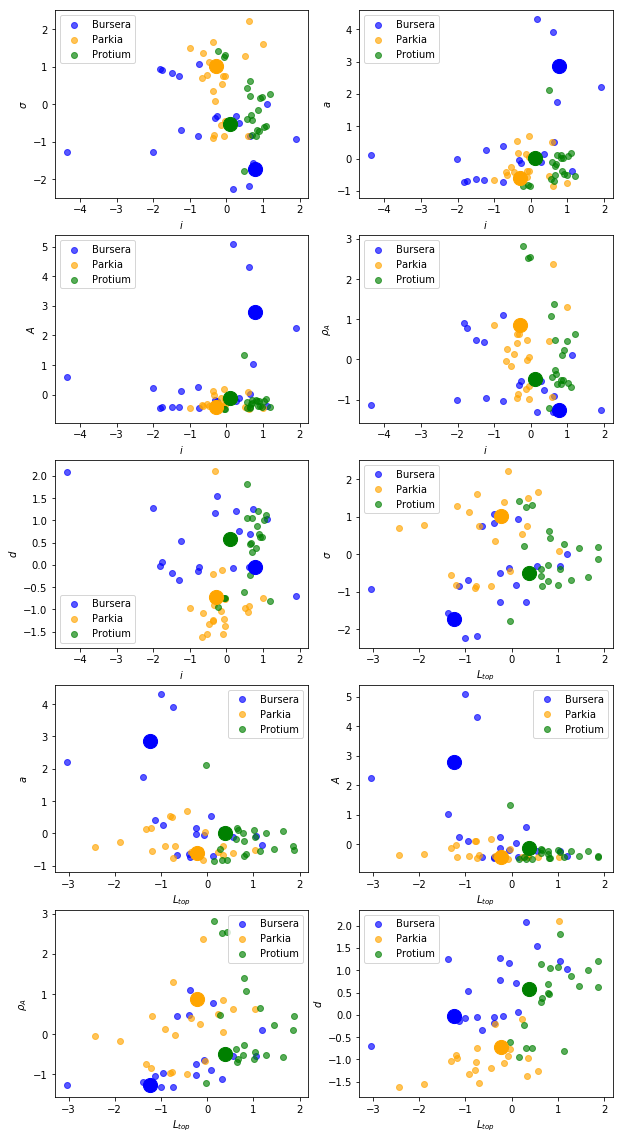

In [14]:
n_features = len(feature_names)
colors = ['blue', 'orange', 'green', 'red', 'violet']
index_pairs = [[1, b] for b in range(2, n_features)] + [[0, b] for b in range(2, n_features)]
fig, axes = plt.subplots(5, 2, figsize=(10,20))

for ax, feature_indices in zip(axes.flat, index_pairs):
    for genus, color in zip(genera_ge4, colors):       
        X_genus = X[[k for k, network_id in enumerate(network_ids_ge4) if network_id in networks_from_genus[genus]],:]

        x = X_genus[:, feature_indices[0]]
        y = X_genus[:, feature_indices[1]]

        ax.scatter(x, y, label=genus, color=color, alpha=0.65)
        ax.scatter(center_from_genus[genus][feature_indices[0]], center_from_genus[genus][feature_indices[1]], color=color, s=200, zorder=2)

    ax.set_xlabel(feature_labels[feature_names[feature_indices[0]]])
    ax.set_ylabel(feature_labels[feature_names[feature_indices[1]]])

    ax.legend()
#plt.tight_layout()

### Plot feature vectors for all leaves

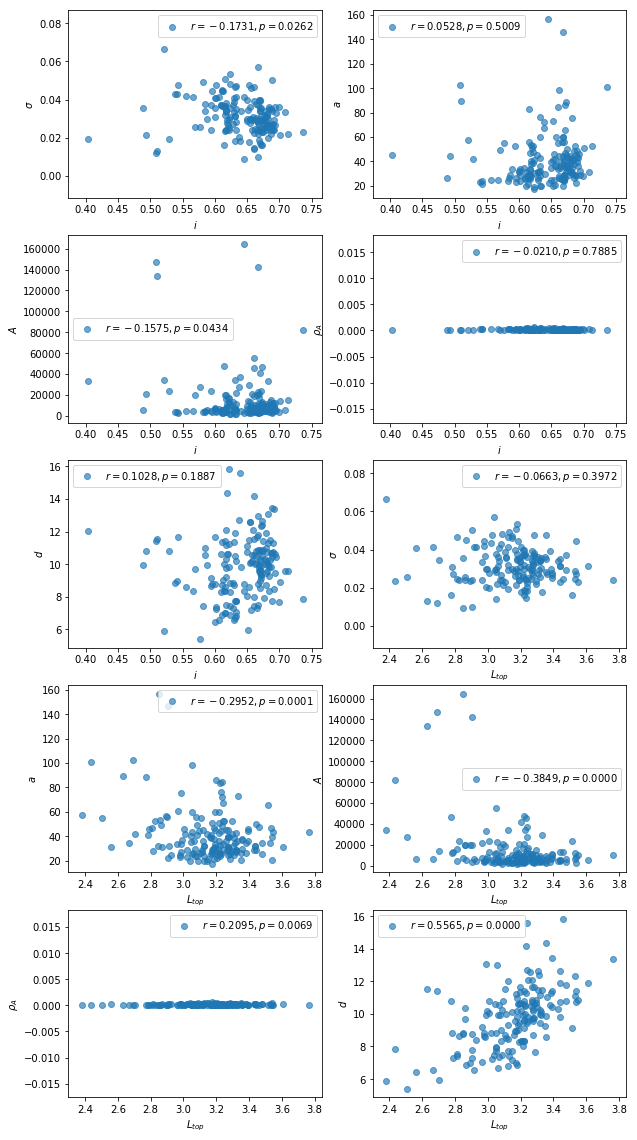

In [18]:
X = []
for feature_name in feature_names:
    row = [data[feature_name][network_id] for network_id in network_ids]
    X.append(row)
X = np.array(X)
X = X.T
X = np.array([row for row in X if row[4] < 300000])

colors = ['blue', 'orange', 'green', 'red', 'violet']
index_pairs = [[1, b] for b in range(2, 7)] + [[0, b] for b in range(2, 7)]
fig, axes = plt.subplots(5, 2, figsize=(10,20))

for ax, feature_indices in zip(axes.flat, index_pairs):

    x = X[:, feature_indices[0]]
    y = X[:, feature_indices[1]]
    
    r, p = scipy.stats.pearsonr(x, y)

    ax.scatter(x, y, alpha=0.65, label=r'$r={0:.4f}, p={1:.4f}$'.format(r, p))

    ax.set_xlabel(feature_labels[feature_names[feature_indices[0]]])
    ax.set_ylabel(feature_labels[feature_names[feature_indices[1]]])
    ax.legend()

#plt.tight_layout()

## Leaf Cuts

In [19]:
segmented_network_ids = [
    'BronxA_009', # Brusera gracilipes
    'BronxA_010',
    'BronxA_016', # Protium calanense
    'BronxA_019',
    'BronxA_070', # Apuleia leiocarpa
    'BronxA_071',
    'BronxA_088', # Dalbergia miscolobium
    'BronxA_109',
    'BronxA_075', # Cedrela odorata
    'BronxA_119',   
]

### Segment leaves

In [ ]:
for network_id in segmented_network_ids:
    print('Generating segmens for {}'.format(network_id))
    path = 'data/networks-BronxA/{}_binary_corrected_graph.'.format(network_id)
    _, G = graph_from_data(path + 'node_positions.txt', path + 'edgelist.txt')
    partition_graph(network_id, G)

### Plot segmentation example

/Users/Ben/anaconda3/envs/leaf/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/Ben/anaconda3/envs/leaf/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/Ben/anaconda3/envs/leaf/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/Ben/anaconda3/envs/leaf/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 

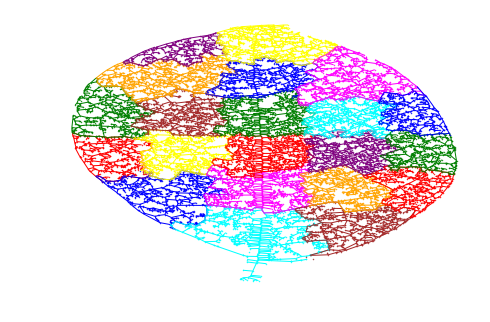

In [20]:
network_id = 'BronxA_009'
path_base = 'data/segments/{}'.format(network_id)
file_names = os.listdir(path_base)
colors = itertools.cycle(['red', 'green', 'blue', 'yellow', 'brown', 'orange', 'purple', 'cyan', 'magenta'])

for file_name in file_names:
    file_path = os.path.join(path_base, file_name)
    segment = nx.read_gpickle(file_path)
    color = next(colors)
    pos = nx.get_node_attributes(segment, 'pos')
    nx.draw(segment, pos=pos, node_size=0.2, edge_size=0.1, node_color=color, edge_color=color)

### Cluster leaf segments

In [21]:
feature_names_to_load = [
 'topological_length',
 'nesting_numbers',
 'vein_density',
 'vein_distance',
 'areole_area',
 'areole_density',
 'weighted_vein_thickness',
 'average_node_degree',
 'n_edges',
 'n_nodes',
]
data = {}
cell_positions = {network_id: {} for network_id in segmented_network_ids}
for feature_name in feature_names_to_load:
    if feature_name == 'nesting_numbers':
        values_list = [{network_id: {} for network_id in segmented_network_ids} for _ in range(4)]
        with open('features/segments/{}'.format(feature_name)) as file:
            reader = csv.reader(file, delimiter='\t')
            for row in reader:
                network_id = row[0]
                seg_number = row[1]
                rel_x = float(row[2])
                rel_y = float(row[3])
                value = float(row[4])
                for k, value in enumerate([float(x) for x in row[4:]]):
                    values_list[k][network_id][seg_number] = value
                cell_positions[network_id][seg_number] = [rel_x, rel_y]
        data['nesting_number_weighted'] = values_list[0]
        data['nesting_number_weighted_no_ext'] = values_list[1]
        data['nesting_number_unweighted'] = values_list[2]
        data['nesting_number_unweighted_no_ext'] = values_list[3]
    else:
        values = {network_id: {} for network_id in segmented_network_ids}
        with open('features/segments/{}'.format(feature_name)) as file:
            reader = csv.reader(file, delimiter='\t')
            for row in reader:
                network_id = row[0]
                seg_number = row[1]
                rel_x = float(row[2])
                rel_y = float(row[3])
                value = float(row[4])
                values[network_id][seg_number] = value
        data[feature_name] = values
seg_numbers = {network_id: sorted(data['vein_distance'][network_id].keys()) for network_id in segmented_network_ids}

In [23]:
X = []
for feature_name in feature_names:
    row = [data[feature_name][network_id][seg_number] for network_id in segmented_network_ids for seg_number in seg_numbers[network_id]]
    X.append(row)
X = np.array(X)
X = X.T

X = X - np.mean(X, axis=0)
X = X / np.std(X, axis=0)

kmeans = KMeans(n_clusters=5, n_init=60).fit(X)

In [24]:
def color_wheel(x, y):
    rho = np.sqrt(x**2 + y**2)
    if rho > 1:
        rho = 1
    phi = np.arctan2(y, x)
    if phi < 0:
        phi += 2*np.pi
    if 0 <= phi < 2*np.pi/3:
        rgb = [255 - 255*phi/(2*np.pi/3), 0, 255*phi/(2*np.pi/3)]
    if 2*np.pi/3 <= phi < 4*np.pi/3:
        rgb = [0, 255*(phi - 2*np.pi/3)/(2*np.pi/3), 255 - 255*(phi - 2*np.pi/3)/(2*np.pi/3)]
    if 4*np.pi/3 <= phi < 2*np.pi:
        rgb = [255*(phi - 4*np.pi/3)/(2*np.pi/3), 255 - 255*(phi - 4*np.pi/3)/(2*np.pi/3), 0]
    #color = [c * rho / 255 for c in rgb]
    color = [c / 255 for c in rgb]
    return matplotlib.colors.to_rgb(color)

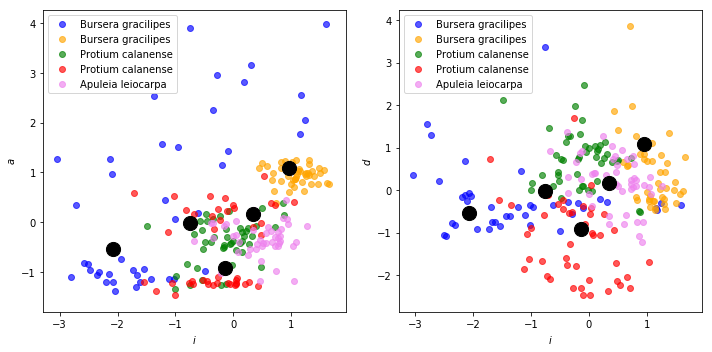

In [27]:
n_features = len(feature_names)
colors = ['blue', 'orange', 'green', 'red', 'violet']
index_pairs = [[1, 3], [1, 6]]

fig, axes = plt.subplots(1, 2, figsize=(10,5))
for ax, feature_indices in zip(axes.flat, index_pairs):
    current_index = 0
    for k, color in enumerate(colors):
        n_segments = len(seg_numbers[segmented_network_ids[2*k]]) + len(seg_numbers[segmented_network_ids[2*k+1]])
        x = X[current_index:current_index + n_segments, feature_indices[0]]
        y = X[current_index:current_index + n_segments, feature_indices[1]]
        current_index += n_segments
        species = species_from_id(segmented_network_ids[k])
        label = species['genus'] + ' ' + species['species']
        ax.scatter(x, y, label=label, color=color, alpha=0.65)
        ax.scatter(kmeans.cluster_centers_[k][0], kmeans.cluster_centers_[k][1], color='black', s=200, zorder=2)

    ax.set_xlabel(feature_labels[feature_names[feature_indices[0]]])
    ax.set_ylabel(feature_labels[feature_names[feature_indices[1]]])

    ax.legend()
    #plt.savefig('/Users/Ben/Desktop/cluster_segments1', dpi=300)
plt.tight_layout()

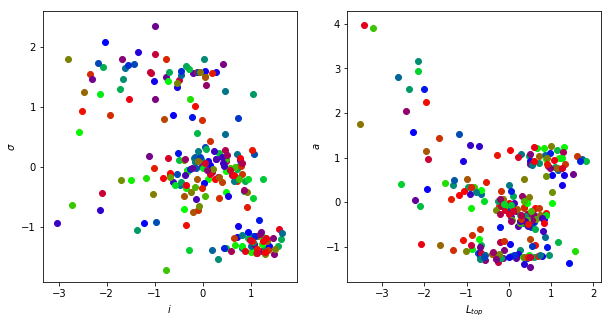

In [28]:
n_features = len(feature_names)
colors = ['blue', 'orange', 'green', 'red', 'violet']
markers = ['o', 'o', 'v', 'v', '>', '>', 's', 's', '*', '*']
index_pairs = [[1, 2], [0, 3]]
fig, axes = plt.subplots(1, 2, figsize=(10,5))

for ax, feature_indices in zip(axes.flat, index_pairs):
    current_index = 0
    for k, network_id in enumerate(segmented_network_ids):
        n_segments = len(seg_numbers[segmented_network_ids[k]])
        for cell_number in range(n_segments):
            cell_position = cell_positions[network_id]['{:02d}'.format(cell_number)]
            x = X[current_index, feature_indices[0]]
            y = X[current_index, feature_indices[1]]
            current_index += 1
            #species = species_from_id(segmented_network_ids[k])
            #label = species['genus'] + ' ' + species['species']
            #ax.scatter(x, y, label=label, color=color, alpha=0.65)
            ax.scatter(x, y, c=[color_wheel(*cell_position)], alpha=1.0)
            #ax.scatter(kmeans.cluster_centers_[k][0], kmeans.cluster_centers_[k][1], color='black', s=200, zorder=2)

    ax.set_xlabel(feature_labels[feature_names[feature_indices[0]]])
    ax.set_ylabel(feature_labels[feature_names[feature_indices[1]]])

    #plt.savefig('/Users/Ben/Desktop/segments_cluster_pos1', dpi=300)
    #ax.legend()
#plt.tight_layout()

# Random Networks

In [ ]:
feature_functions = [nesting_numbers, weighted_vein_thickness, topological_length]

network_ids = ['BronxA_009', 'BronxA_016', 'BronxA_070',
               'BronxA_075', 'BronxA_109']

distributions = {network_id: {} for network_id in network_ids}

for network_id in network_ids:
    print(network_id)
    file_list = sorted(os.listdir('data/segments/{}'.format(network_id)))
    segment = file_list[9]
    random_graph = nx.read_gpickle('data/segments/{}/{}'.format(network_id, segment))
    cycles = []
    
    nesting_number_list = []
    vein_thickness_list = []
    topo_length_list = []
    weights = [random_graph[edge[0]][edge[1]]['radius'] for edge in random_graph.edges()]
    av_weight = np.average(weights)
    sdv_weight = np.std(weights)
    for k in range(100):
        print(k)
        
        #Assign random weight from normal Gaussian distribution with  mean = av_weight to random network
        random_values = np.random.normal(av_weight, sdv_weight, nx.number_of_edges(random_graph))
        for edge, value in zip(random_graph.edges(), random_values): 
            random_graph.edge[edge[0]][edge[1]]['radius'] = value
            random_graph.edge[edge[0]][edge[1]]['conductivity'] = value
            
        clean_random_graph = clean_graph(random_graph)        
        
        _, _, _, nesting_number = nesting_numbers(clean_random_graph, cycles)
        vein_thickness = weighted_vein_thickness(random_graph, cycles)
        topo_length = topological_length(clean_random_graph, cycles)
        
        nesting_number_list.append(nesting_number)
        vein_thickness_list.append(vein_thickness)
        topo_length_list.append(topo_length)
        
        distributions[network_id]['nesting_number'] = nesting_number_list
        distributions[network_id]['vein_thickness'] = vein_thickness_list
        distributions[network_id]['topological_length'] = topo_length_list
pickle.dump(distributions, open('distributions', 'wb'))

In [ ]:
distributions = pickle.load(open('distributions', 'rb'))

In [ ]:
for network_id in network_ids:
    for feature_name in ['nesting_number', 'topological_length']:
        plt.figure()
        n, bins, patches = plt.hist(distributions[network_id][feature_name], 50, normed=0, facecolor='green', alpha=0.80, label='Random segments\n (real value=0.62)')
        plt.xlabel(feature_name)
        plt.ylabel('Counts')
        plt.legend()